In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import time
from collections import defaultdict
from scipy.spatial import distance
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation

In [ ]:
model = Sequential([
    
    # reshape 28 row * 28 column data to 28*28 rows
    Flatten(input_shape=(7,1)),
    
      # dense layer 1
    Dense(32, activation='sigmoid'),  
    
    # dense layer 2
    Dense(32, activation='sigmoid'),

    Dense(32, activation='sigmoid'),
    Dense(32, activation='sigmoid'), 
      # output layer
    Dense(1, activation='sigmoid'),  
])

model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 7)                 0         
                                                                 
 dense (Dense)               (None, 32)                256       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,457
Trainable params: 3,457
Non-trainabl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/6240_project/project_data/

/content/drive/MyDrive/6240_project/project_data


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/6240_project/project_data/interaction.csv')

In [ ]:
train_data, test_data = train_test_split(df,test_size=0.2)

In [ ]:
train_data.reset_index(drop=True,inplace=True)
test_data.reset_index(drop=True,inplace=True)

In [ ]:
user_indices = train_data['uid']

In [ ]:
item_indices = train_data['bid']

In [ ]:
ratings = train_data['rating']

In [ ]:
test_users = torch.LongTensor(test_data['uid'])
test_items = torch.LongTensor(test_data['bid'])
test_ratings = torch.LongTensor(test_data['rating'])

In [ ]:
from torch.utils.data import DataLoader, Dataset
class UserItemRatingDataset(Dataset):
    """Wrapper, convert <user, item, rating> Tensor into Pytorch Dataset"""
    def __init__(self, user_tensor, item_tensor, target_tensor):
        """
        args:
            target_tensor: torch.Tensor, the corresponding rating for <user, item> pair
        """
        self.user_tensor = user_tensor
        self.item_tensor = item_tensor
        self.target_tensor = target_tensor

    def __getitem__(self, index):
        return self.user_tensor[index], self.item_tensor[index], self.target_tensor[index]

    def __len__(self):
        return self.user_tensor.size(0)

In [ ]:
dataset = UserItemRatingDataset(user_tensor=torch.LongTensor(user_indices),
                                        item_tensor=torch.LongTensor(item_indices),
                                        target_tensor=torch.FloatTensor(ratings))
data_loader = DataLoader(dataset, batch_size=256, shuffle=True)

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # self.config = config
        # self.num_users = config['num_users']
        # self.num_items = config['num_items']
        # self.latent_dim = config['latent_dim']

        self.num_users = 267821
        self.num_items = 36182
        self.latent_dim = 64

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        config = {}
        config['layers'] = [128,64,32,16,8]
        self.output = nn.Linear(8,1)
        self.relu = nn.ReLU()
        
        self.fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(config['layers'][:-1], config['layers'][1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        # self.affine_output = torch.nn.Linear(in_features=config['layers'][-1], out_features=1)
        # self.logistic = torch.nn.Sigmoid()


    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        # print(user_embedding.shape,item_embedding.shape)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)  # the concat latent vector
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = torch.nn.ReLU()(vector)
            # vector = torch.nn.BatchNorm1d()(vector)
            # vector = torch.nn.Dropout(p=0.5)(vector)
        
        # x = vector
        x = self.output(vector)
        output = self.relu(x)

        # logits = self.affine_output(vector)
        # rating = self.logistic(logits)
        # return rating
        return output


In [ ]:
MLP_model = MLP()
MLP_model.cuda()

MLP(
  (embedding_user): Embedding(267821, 64)
  (embedding_item): Embedding(36182, 64)
  (output): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (fc_layers): ModuleList(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=8, bias=True)
  )
)

In [ ]:
MAE_list = []
MSE_list = []
RMSE_list = []

In [ ]:
assert torch.cuda.is_available(), 'CUDA is not available'
torch.cuda.set_device(0)

In [ ]:
def MLP_train(data_loader,MLP_model,test_users,test_items,test_ratings,epochs=15):
    """
    Arguments: 
    training_data (str-type numpy.array): the training data containing user_id, movie_id, and normalized rating (0-1) information.
    user_emb and item_emb (dictionaries of numpy.array): pre-trained embeddings of users and items. 
    - The keys are user_id (string) and item_id (string), and the values are the corresponding embeddings (numpy.array; dim=32) of user_id and item_id, respectively.
    MLP_model (MLP class): the untrained MLP model.
    epochs (int): number of iterations required for updating the MLP model.

    Returns:
    MLP_model (MLP class): the MLP model trained with given training data and pre-trained embeddings.

    Steps for the first code block:
    1. for each training example, retrieve pre-trained embeddings for a user u and item i.
    2. concatenate those embeddings by np.concatenate((user_emb_of_u,item_emb_of_i)) and append it to a list.
    3. convert a list of concatenated embeddings to a PyTorch FloatTensor by torch.FloatTensor(np.array(list)).
    """
    torch.manual_seed(0)
    np.random.seed(0)

    # input_data = torch.FloatTensor(np.array(l))

  #################################
  
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(MLP_model.parameters(),weight_decay=5e-5)

    for epoch in tqdm(range(epochs)):
        """  
    Steps for the second code block:
    1. set the gradients to zero before backpropragation by optimizer.zero_grad().
    2. call the prediction function of the MLP model by MLP_model(input_data).flatten() and obtain the prediction result for the input data, 
       where the input data is a PyTorch FloatTensor from Step 3 of the previous code block.
    3. obtain the ground-truth rating values from training_data (in torch.FloatTensor format; use torch.FloatTensor(np.array) for type conversion).
    4. compute the loss by loss=criterion(prediction,ground_truth).
    5. perform backpropragation by loss.backward().
    6. update the model parameters by optimizer.step().
    7. compute the differences between the prediction and ground_truth by (prediction-ground_truth).detach().numpy().
    8. compute and print training RMSE using the differences for every 10 epochs (epoch 0, epoch 10, ..., epoch 190).
        - Don't use loss in Step 4 to derive training RMSE 
        """
        optimizer.zero_grad()

        for batch_id, batch in enumerate(data_loader):
            # assert isinstance(batch[0], torch.LongTensor)
            # print(batch_id)
            user, item, rating = batch[0], batch[1], batch[2]
            user, item, rating = user.cuda(), item.cuda(), rating.cuda()
            # print(user.shape,rating.shape,item.shape)
            prediction = MLP_model(user,item).flatten()
            # ground_truth = torch.FloatTensor(training_data[:,2:].astype(np.float32).reshape(len(training_data)))
            ground_truth = rating.flatten()

            # print(prediction.shape,ground_truth.shape)
            
            loss = criterion(prediction,ground_truth)
            loss.backward()
            optimizer.step()

            diff = (prediction-ground_truth).detach().cpu().numpy()
            rmse = (np.mean(diff**2))**0.5

            abs_diff = np.absolute(diff)
            mae = np.mean(abs_diff)
            if batch_id % 500 == 0:
            # # if epoch % 10 == 0:
              print("rmse:", rmse, "mse:",loss, "mae:",mae)
              # MAE_list.append(mae)
              # MSE_list.append(loss)
              # RMSE_list.append(rmse)
      
        test_users, test_items, test_ratings = test_users.cuda(), test_items.cuda(), test_ratings.cuda()
        test_preds = MLP_model(test_users,test_items).flatten()

        diff = (test_preds-test_ratings).detach().cpu().numpy()
        rmse = (np.mean(diff**2))**0.5

        abs_diff = np.absolute(diff)
        mae = np.mean(abs_diff)
        
        print("test_metrics........","rmse:", rmse, "mse:",loss, "mae:",mae)

        MAE_list.append(mae)
        MSE_list.append(loss)
        RMSE_list.append(rmse)

            
    #################################
    return MLP_model

In [ ]:
trained_MLP_model = MLP_train(data_loader,MLP_model,test_users,test_items,test_ratings)

  0%|          | 0/15 [00:00<?, ?it/s]

rmse: 4.064422621972277 mse: tensor(16.5195, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 3.9335938
rmse: 4.109820555693399 mse: tensor(16.8906, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 4.0
rmse: 3.5179587523106326 mse: tensor(12.3760, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 3.3700595
rmse: 1.765858997604329 mse: tensor(3.1183, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 1.5446987
rmse: 0.9209513482177814 mse: tensor(0.8482, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.74372554
rmse: 1.4207440584089712 mse: tensor(2.0185, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 1.2299017
rmse: 1.3106024512887562 mse: tensor(1.7177, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 1.1698041
rmse: 1.3220644280810885 mse: tensor(1.7479, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.9907744


  7%|▋         | 1/15 [01:11<16:34, 71.05s/it]

test_metrics........ rmse: 1.0772488115843695 mse: tensor(1.2319, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.9418017
rmse: 1.0832361886900155 mse: tensor(1.1734, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.9481499
rmse: 1.0156273475032966 mse: tensor(1.0315, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.81041616
rmse: 0.9388583832612272 mse: tensor(0.8815, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.73990786
rmse: 1.0514152911281203 mse: tensor(1.1055, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.824322
rmse: 1.0480579695539132 mse: tensor(1.0984, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.9016074
rmse: 0.9786724033508069 mse: tensor(0.9578, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8355589
rmse: 0.9630430151264089 mse: tensor(0.9275, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7835245
rmse: 0.9180670827589819 mse: tensor(0.8428, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.76236975


 13%|█▎        | 2/15 [02:24<15:43, 72.58s/it]

test_metrics........ rmse: 1.0464819554624536 mse: tensor(1.0595, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.835371
rmse: 1.007145032232964 mse: tensor(1.0143, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8019578
rmse: 0.9692758548093363 mse: tensor(0.9395, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.795833
rmse: 1.1067694570495425 mse: tensor(1.2249, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.94092643
rmse: 1.0383011172355012 mse: tensor(1.0781, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.88140774
rmse: 0.9545055459502348 mse: tensor(0.9111, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7892357
rmse: 1.1032846934976988 mse: tensor(1.2172, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8858588
rmse: 0.9487669069495068 mse: tensor(0.9002, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.80131865
rmse: 1.0130094447472318 mse: tensor(1.0262, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.87838185


 20%|██        | 3/15 [03:34<14:14, 71.22s/it]

test_metrics........ rmse: 0.9801623713020798 mse: tensor(0.9322, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7788421
rmse: 0.9359494420278408 mse: tensor(0.8760, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.77157205
rmse: 1.011502865178665 mse: tensor(1.0231, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7928933
rmse: 0.9180405933592753 mse: tensor(0.8428, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.72712576
rmse: 0.9754493778180434 mse: tensor(0.9515, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7816359
rmse: 1.0080610456714574 mse: tensor(1.0162, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8030671
rmse: 0.9938475770848143 mse: tensor(0.9877, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.775198
rmse: 0.9706372060210926 mse: tensor(0.9421, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.76091325
rmse: 1.005312635844479 mse: tensor(1.0107, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8198412


 27%|██▋       | 4/15 [04:43<12:55, 70.54s/it]

test_metrics........ rmse: 0.9932655725206523 mse: tensor(0.9826, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.79875714
rmse: 1.0559398985940198 mse: tensor(1.1150, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.82558537
rmse: 0.971126870705311 mse: tensor(0.9431, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.82113963
rmse: 0.9130396540534055 mse: tensor(0.8336, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7374691
rmse: 0.8908046072838612 mse: tensor(0.7935, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7077347
rmse: 0.969216142300682 mse: tensor(0.9394, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.78013945
rmse: 0.9424932069305969 mse: tensor(0.8883, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.76455414
rmse: 1.018938791299126 mse: tensor(1.0382, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8113676
rmse: 1.0468699896393627 mse: tensor(1.0959, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8526372


 33%|███▎      | 5/15 [05:52<11:39, 69.94s/it]

test_metrics........ rmse: 1.008812223687408 mse: tensor(1.0302, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.81236905
rmse: 1.0089722104286303 mse: tensor(1.0180, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.79596066
rmse: 1.0172948168324893 mse: tensor(1.0349, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.85772
rmse: 0.9755522728840375 mse: tensor(0.9517, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.789166
rmse: 0.9811733495332305 mse: tensor(0.9627, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8032963
rmse: 0.9137045982864703 mse: tensor(0.8349, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7489833
rmse: 0.9671872362373745 mse: tensor(0.9355, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.75110054
rmse: 1.0184362384686494 mse: tensor(1.0372, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8356495
rmse: 0.9138262842901254 mse: tensor(0.8351, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7454729


 40%|████      | 6/15 [07:01<10:26, 69.56s/it]

test_metrics........ rmse: 0.9929518871541269 mse: tensor(1.0606, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.80880004
rmse: 1.0237452502949773 mse: tensor(1.0481, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.82751274
rmse: 0.9984660901198406 mse: tensor(0.9969, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.80531263
rmse: 1.0014462741300065 mse: tensor(1.0029, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7850165
rmse: 0.9749606002280657 mse: tensor(0.9505, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7794514
rmse: 1.0181338500591917 mse: tensor(1.0366, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.807948
rmse: 0.9568441402708969 mse: tensor(0.9156, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7465367
rmse: 0.9057397392464593 mse: tensor(0.8204, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7122886
rmse: 0.9524613242920448 mse: tensor(0.9072, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7747772


 47%|████▋     | 7/15 [08:10<09:14, 69.33s/it]

test_metrics........ rmse: 1.0128447993423926 mse: tensor(0.8923, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8153073
rmse: 1.0510552485142646 mse: tensor(1.1047, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.84675324
rmse: 1.0386115221247938 mse: tensor(1.0787, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8982817
rmse: 0.9621361800380929 mse: tensor(0.9257, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.752511
rmse: 0.9881519640163705 mse: tensor(0.9764, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7924149
rmse: 0.980272676232364 mse: tensor(0.9609, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7614982
rmse: 0.9168885388769162 mse: tensor(0.8407, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.737911
rmse: 1.0694720455973064 mse: tensor(1.1438, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.9094208
rmse: 1.09406248805796 mse: tensor(1.1970, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.87398124


 53%|█████▎    | 8/15 [09:19<08:04, 69.15s/it]

test_metrics........ rmse: 0.9802049684753932 mse: tensor(0.9809, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.778959
rmse: 1.0001581186218398 mse: tensor(1.0003, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.77473855
rmse: 1.000052212305761 mse: tensor(1.0001, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.77473414
rmse: 1.0215284290624278 mse: tensor(1.0435, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.81103647
rmse: 0.9358397724159944 mse: tensor(0.8758, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.73471093
rmse: 0.9887709478674266 mse: tensor(0.9777, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.80778354
rmse: 0.9480625536376246 mse: tensor(0.8988, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7475734
rmse: 1.0612028843426033 mse: tensor(1.1262, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8363641
rmse: 0.8890254061558237 mse: tensor(0.7904, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.70428765


 60%|██████    | 9/15 [10:27<06:54, 69.05s/it]

test_metrics........ rmse: 0.9785054828780626 mse: tensor(0.9900, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.77273536
rmse: 1.0532001321406415 mse: tensor(1.1092, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.83171105
rmse: 1.020856908928215 mse: tensor(1.0421, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7921904
rmse: 0.9755130469477689 mse: tensor(0.9516, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7212018
rmse: 0.9290071129480391 mse: tensor(0.8631, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.76535267
rmse: 0.9888597687411508 mse: tensor(0.9778, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7664662
rmse: 0.9460751948281405 mse: tensor(0.8951, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7616433
rmse: 1.0739759136035074 mse: tensor(1.1534, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8532136
rmse: 0.8987868583453554 mse: tensor(0.8078, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.72707087


 67%|██████▋   | 10/15 [11:36<05:44, 68.95s/it]

test_metrics........ rmse: 0.9808328871832659 mse: tensor(0.9173, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.76272565
rmse: 1.0062377218125258 mse: tensor(1.0125, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.79920244
rmse: 1.0729934640207166 mse: tensor(1.1513, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.81331956
rmse: 1.015884014260032 mse: tensor(1.0320, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.80372024
rmse: 0.9587453633660076 mse: tensor(0.9192, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7549231
rmse: 0.9801928371349083 mse: tensor(0.9608, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7573892
rmse: 1.0192528706356492 mse: tensor(1.0389, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7536282
rmse: 0.966397659645973 mse: tensor(0.9339, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7702377
rmse: 0.9346699915616824 mse: tensor(0.8736, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.75745577


 73%|███████▎  | 11/15 [12:46<04:36, 69.19s/it]

test_metrics........ rmse: 0.9804637346481381 mse: tensor(1.2118, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7603486
rmse: 0.98632051068379 mse: tensor(0.9728, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7887453
rmse: 0.9717098365592024 mse: tensor(0.9442, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7834439
rmse: 1.0124750440371229 mse: tensor(1.0251, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7780443
rmse: 1.0401441637402553 mse: tensor(1.0819, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.85576403
rmse: 1.072560865546909 mse: tensor(1.1504, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.87192845
rmse: 0.9677722980942933 mse: tensor(0.9366, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.753993
rmse: 0.992321996508973 mse: tensor(0.9847, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.801743
rmse: 0.9414587045831885 mse: tensor(0.8863, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7819335


 80%|████████  | 12/15 [13:56<03:28, 69.35s/it]

test_metrics........ rmse: 0.9974170646034569 mse: tensor(1.1366, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.80287546
rmse: 1.0225368351352306 mse: tensor(1.0456, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7923988
rmse: 1.0146912023290555 mse: tensor(1.0296, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.82518995
rmse: 0.9791606064196325 mse: tensor(0.9588, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.76620585
rmse: 0.9840473356317192 mse: tensor(0.9683, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.80532384
rmse: 0.9687067760545967 mse: tensor(0.9384, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.790572
rmse: 0.9531383826144889 mse: tensor(0.9085, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7791667
rmse: 0.9938711164549983 mse: tensor(0.9878, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.82387537
rmse: 0.9781800568414257 mse: tensor(0.9568, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.77881426


 87%|████████▋ | 13/15 [15:05<02:18, 69.25s/it]

test_metrics........ rmse: 0.9779724928453177 mse: tensor(0.8898, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7671599
rmse: 1.0255318680623724 mse: tensor(1.0517, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.80266845
rmse: 1.045889490197928 mse: tensor(1.0939, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7921303
rmse: 0.9698717329420347 mse: tensor(0.9407, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.76403415
rmse: 0.956719546257758 mse: tensor(0.9153, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7814892
rmse: 1.0527797823651728 mse: tensor(1.1083, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8216046
rmse: 0.8950290877128074 mse: tensor(0.8011, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.6986102
rmse: 0.9725988593271114 mse: tensor(0.9459, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.759773
rmse: 0.9829261047009339 mse: tensor(0.9661, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7870057


 93%|█████████▎| 14/15 [16:14<01:09, 69.19s/it]

test_metrics........ rmse: 0.9779842251030042 mse: tensor(0.8168, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.76581174
rmse: 0.993697301798886 mse: tensor(0.9874, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.77286625
rmse: 1.030491752454541 mse: tensor(1.0619, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8140024
rmse: 0.9005009382943069 mse: tensor(0.8109, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.74483204
rmse: 0.9499118927202812 mse: tensor(0.9023, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7242751
rmse: 0.9408046335438722 mse: tensor(0.8851, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7641009
rmse: 1.0215392234766703 mse: tensor(1.0435, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.79742515
rmse: 0.993381832707486 mse: tensor(0.9868, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7853703
rmse: 0.9996471974774093 mse: tensor(0.9993, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.81527


100%|██████████| 15/15 [17:23<00:00, 69.57s/it]

test_metrics........ rmse: 1.003893959771711 mse: tensor(1.0954, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8085241


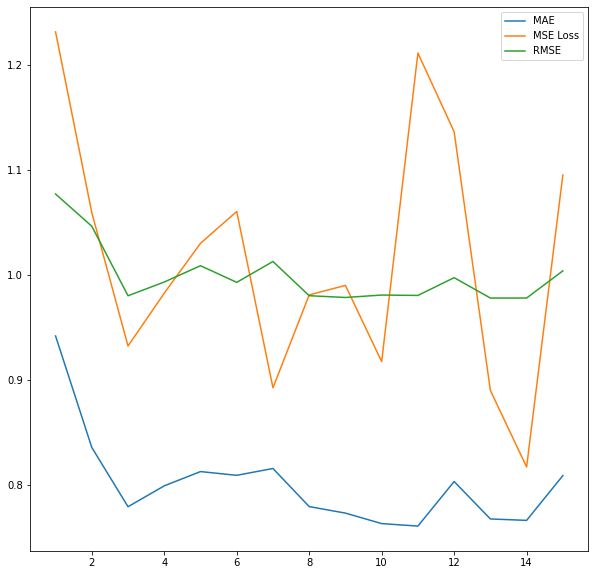

In [ ]:
MSE_list = [c.cpu().detach().numpy() for c in MSE_list]
plt.figure(figsize=(10,10))
x = list(range(1,(len(MAE_list)+1))) 
plt.plot(x,MAE_list,label='MAE')
plt.plot(x,MSE_list,label='MSE Loss')
plt.plot(x,RMSE_list,label='RMSE')
plt.legend()
# plt.show()
plt.savefig('ncf_64.png')

In [ ]:
torch.save(trained_MLP_model,'/content/drive/MyDrive/6240_project/project_data/ncf_model_64')

NameError: ignored

In [ ]:
# 32 test_metrics........ rmse: 0.9779439691590593 mse: tensor(0.9189, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7617227
# 64 test_metrics........ rmse: 1.003893959771711 mse: tensor(1.0954, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8085241
